In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [25]:
# Load data
data = pd.read_csv('../../data/behavioral_data.csv')
# Filter out trials with RT < 0.2 or response_int.isna()
data = data.query('RT > 0.2 & response_int.notna()')
# Create a column called gain/loss
data['gain/loss'] = data['gain'] / data['loss']

In [31]:
print(data['sub'].unique())

[  3   5   6   9  10  11  14  19  20  22  25  30  33  36  39  40  43  45
  47  49  52  53  54  58  60  61  62  63  64  66  70  71  74  75  76  79
  80  81  82  84  85  87  89  94  95  98  99 102 105 109 115 118 123 124]


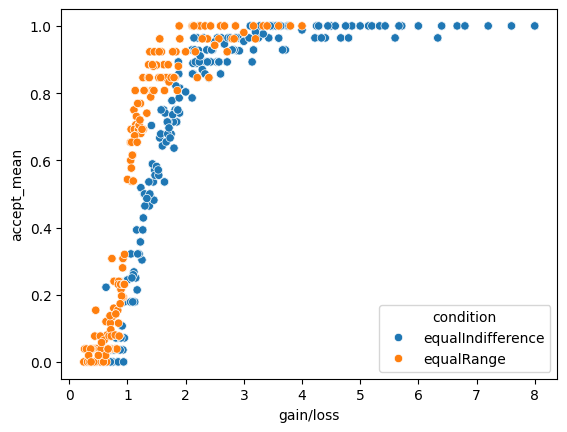

In [22]:
# For each condition, scatter plot of x-axis as gain/loss and y-axis as probability of accepting
# For probability of accepting, use the mean of the accept column for each group of gain/loss and condition
data['accept_mean'] = data.groupby(['gain/loss', 'condition'])['accept'].transform('mean')
sns.scatterplot(data=data, x='gain/loss', y='accept_mean', hue='condition')
plt.show()


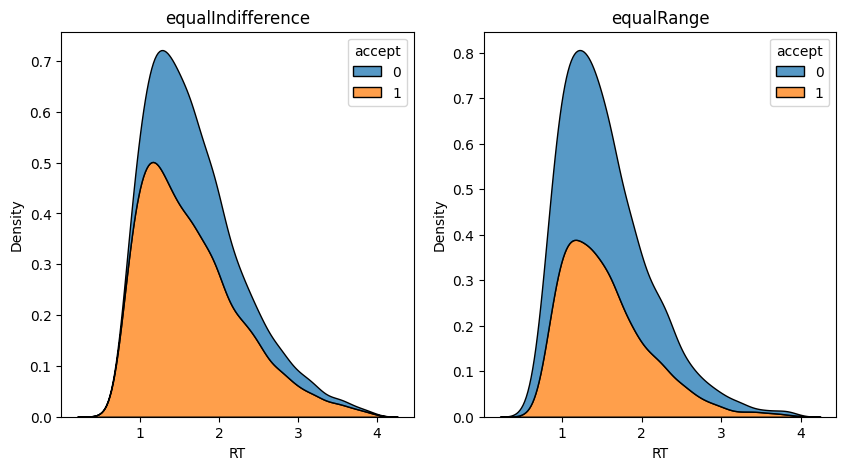

In [23]:
# For each condition, do a histograme of RT based on accept
# Figure with two subplots, one for each condition
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.kdeplot(data=data.query('condition == "equalIndifference"'), x='RT', hue='accept', multiple='stack', label='equalIndifference', ax=axs[0])
sns.kdeplot(data=data.query('condition == "equalRange"'), x='RT', hue='accept', multiple='stack', label='equalRange', ax=axs[1])
axs[0].set_title('equalIndifference')
axs[1].set_title('equalRange')
plt.show()


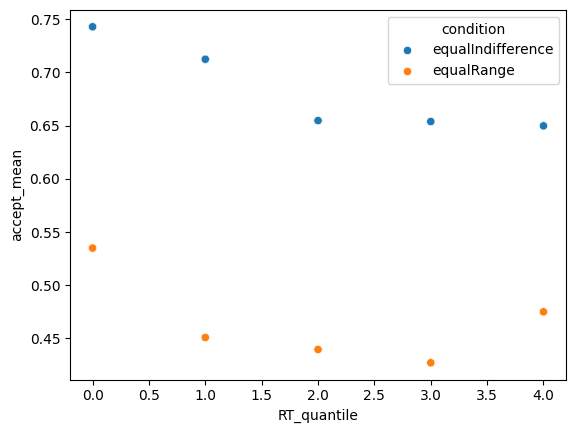

In [20]:
# Divide the RT into 5 quantiles per subject
data['RT_quantile'] = data.groupby('sub')['RT'].transform(lambda x: pd.qcut(x, 5, labels=False))
# For each condition, plot the mean of the accept column for each group of RT_quantile for accept == 1 and accept ==
data['accept_mean'] = data.groupby(['RT_quantile', 'condition'])['accept'].transform('mean')
sns.scatterplot(data=data, x='RT_quantile', y='accept_mean', hue='condition')
plt.show()


In [19]:
data

,Unnamed: 0,sub,run,condition,gain,loss,RT,accept,response_int,participant_response,trial,uncertain,dist_from_indiff,gain/loss,accept_mean,RT_quantile
0,512,3,1,equalIndifference,14,14,1.247,1,4.0,strongly_accept,1,0,0.000000,1.000000,0.238095,2
1,513,3,1,equalIndifference,38,14,1.041,1,4.0,strongly_accept,2,0,16.970563,2.714286,0.892857,1
2,514,3,1,equalIndifference,10,18,2.803,1,3.0,weakly_accept,3,1,5.656854,0.555556,0.071429,4
3,515,3,1,equalIndifference,16,5,0.936,1,4.0,strongly_accept,4,0,7.778175,3.200000,0.982143,0
4,516,3,1,equalIndifference,40,12,1.142,1,4.0,strongly_accept,5,0,19.798990,3.333333,0.976190,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13819,27643,124,4,equalRange,7,14,1.235,0,1.0,strongly_reject,252,0,4.949747,0.500000,0.019231,1
13820,27644,124,4,equalRange,5,9,1.236,0,1.0,strongly_reject,253,0,2.828427,0.555556,0.057692,1
13821,27645,124,4,equalRange,5,15,1.030,0,1.0,strongly_reject,254,0,7.071068,0.333333,0.019231,0
13822,27646,124,4,equalRange,12,18,1.029,0,1.0,strongly_reject,255,0,4.242641,0.666667,0.038462,0
